In [1]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

%matplotlib notebook

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

Notes:
- Mean number of products per order: 75-100
- Different pallet types in the same order
- Same container type in the same order
- Item rotation not allowed

In [3]:
def half_gaussian(scale, size=1, reduction_factor=1):
    return np.ceil(np.abs(np.random.normal(scale=scale / reduction_factor, size=size))).astype(int)

In [4]:
def gen_products(num_products, max_lenght, max_width, max_height, max_weight):
    lenghts = half_gaussian(max_lenght, size=num_products, reduction_factor=4).reshape(-1, 1)
    widths = half_gaussian(max_width, size=num_products, reduction_factor=4).reshape(-1, 1)
    heights = half_gaussian(max_height, size=num_products, reduction_factor=4).reshape(-1, 1)
    weights = half_gaussian(max_weight, size=num_products, reduction_factor=50).reshape(-1, 1)
    data = np.concatenate((lenghts, widths, heights, weights), axis=1)
    return pd.DataFrame(data, columns=["lenght", "width", "height", "weight"])

In [5]:
# Pallet EUR 1 / Container 1A
pallet_lenght, pallet_width, pallet_height = 800, 1200, 145 # mm
container_lenght, container_width, container_height = 2330, 12000, 2200 # mm
pallet_load, container_load = 2490, 26480 # kg

In [6]:
# Product dimension ranges
num_products = 1000
max_product_height = container_height - pallet_height

In [7]:
products_path = "data/products.pkl"
if not os.path.exists(products_path):
    print("Generating products...")
    products = gen_products(
        num_products, 
        pallet_lenght, 
        pallet_width, 
        max_product_height, 
        pallet_load
    )
    products.to_pickle(products_path)
else:
    print("Loading pickled products...")
    products = pd.read_pickle(products_path)
products.head()

Loading pickled products...


,lenght,width,height,weight
0,136,79,459,72
1,244,365,491,11
2,96,410,600,4
3,299,119,477,15
4,128,20,502,55


In [8]:
def get_order(products, ordered_products):
    order = products.sample(ordered_products, replace=True)
    ids = pd.Series(order.index, name="id")
    return pd.concat([ids, order.reset_index(drop=True)], axis=1)

In [9]:
ordered_products = 20

In [10]:
order = get_order(products, ordered_products)
order.head()

,id,lenght,width,height,weight
0,102,212,339,1090,19
1,435,105,55,158,106
2,860,42,822,95,45
3,270,15,256,907,35
4,106,105,380,369,69


In [11]:
def from_blb_to_vertices(x, y, z, l, w, h):
    blb = [x, y, z]
    blf = [x + l, y, z]
    brb = [x, y + w, z]
    brf = [x + l, y + w, z]
    
    tlb = [x, y, z + h]
    tlf = [x + l, y, z + h]
    trb = [x, y + w, z + h]
    trf = [x + l, y + w, z + h]
    
    return np.array([blb, blf, brb, brf, tlb, tlf, trb, trf])

In [12]:
def from_vertices_to_faces(v):
    return np.array([
        [v[0], v[1], v[3], v[2]], # bottom
        [v[4], v[5], v[7], v[6]], # top
        [v[0], v[2], v[6], v[4]], # back
        [v[1], v[3], v[7], v[5]], # front
        [v[0], v[1], v[5], v[4]], # left
        [v[2], v[3], v[7], v[6]], # right
    ])

In [45]:
def add_product_to_pallet(ax, pid, blb, dims):
    v = from_blb_to_vertices(*blb, *dims)
    ax.scatter3D(v[:, 0], v[:, 1], v[:, 2])
    f = from_vertices_to_faces(v)
    ax.add_collection3d(
        Poly3DCollection(
            f, facecolors=np.random.rand(1,3), linewidths=1, edgecolors='r', alpha=.45
        )
    )
    ax.text(blb[0] + dims[0] // 2, blb[1] + dims[1] // 2, blb[2] + dims[2] // 2, pid, size=10, zorder=1,  color='k')
    return ax

In [32]:
def get_pallet(pallet_lenght, pallet_width, max_product_height):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.text(0, 0, 0, "origin", size=10, zorder=1,  color='k')
    ax.view_init(azim=60)
    ax.set_xlim3d(0, pallet_lenght)
    ax.set_ylim3d(0, pallet_width)
    ax.set_zlim3d(0, max_product_height)
    return ax

In [35]:
def plot_pallet(order, ids, blbs, pallet_lenght, pallet_width, max_product_height):
    ax = get_pallet(pallet_lenght, pallet_width, max_product_height)
    for i, blb in zip(ids, blbs):
        ax = add_product_to_pallet(ax, i, blb, (order.iloc[i].lenght, order.iloc[i].width, order.iloc[i].height))
    plt.show()
    return ax

In [16]:
def get_liquid_volume(dims):
    volume = 0
    for dim in dims:
        volume += (dim[0] * dim[1] * dim[2])
    return volume / 1e+9

In [25]:
model = cp_model.CpModel()
max_pallets = ordered_products
Corner = namedtuple("Corner", "x y z")

# Variables
# product_in_pallet[i, j] = 1 if product i is packed in pallet j
product_in_pallet = {}
for i in range(ordered_products):
    for j in range(max_pallets):
        product_in_pallet[(i, j)] = model.NewBoolVar('product_in_pallet_%i_%i' % (i, j))
        
# pallet[i] = 1 if pallet i is used
pallet = {}
for i in range(max_pallets):
    pallet[i] = model.NewBoolVar('pallet_%i' % i)

# blb_corners[i] = [(x_s, x_e), (y_s, y_e), (z_s, z_e)] if product i has blb corner (x_s, y_s, z_s)
blb_corners_start = {}
blb_corners_end = {}
blb_corners_int = {}
for i in range(ordered_products):
    x_s = model.NewIntVar(0, pallet_lenght - int(order.iloc[i].lenght), 'blb_corner_x_start_%i' % i)
    y_s = model.NewIntVar(0, pallet_width - int(order.iloc[i].width), 'blb_corner_y_start_%i' % i)
    z_s = model.NewIntVar(0, max_product_height - int(order.iloc[i].height), 'blb_corner_z_start_%i' % i)
    blb_corners_start[i] = Corner(x_s, y_s, z_s)
    
    x_e = model.NewIntVar(int(order.iloc[i].lenght), pallet_lenght, 'blb_corner_x_end_%i' % i)
    y_e = model.NewIntVar(int(order.iloc[i].width), pallet_width, 'blb_corner_y_end_%i' % i)
    z_e = model.NewIntVar(int(order.iloc[i].height), max_product_height, 'blb_corner_z_end_%i' % i)
    blb_corners_end[i] = Corner(x_e, y_e, z_e)
    
    blb_corners_int[i] = [
        model.NewIntervalVar(x_s, int(order.iloc[i].lenght), x_e, 'blb_corner_x_int_%i' % i),
        model.NewIntervalVar(y_s, int(order.iloc[i].width), y_e, 'blb_corner_y_int_%i' % i),
        model.NewIntervalVar(z_s, int(order.iloc[i].height), z_e, 'blb_corner_z_int_%i' % i)
    ]
    
# prec[i, j, d] = 1 if product i precedes product j on dimension d 
prec = {}
for i in range(ordered_products):
    for j in range(ordered_products):
        if i != j:
            prec[(i, j)] = [
                model.NewBoolVar('%i_before_%i_x' % (i, j)),
                model.NewBoolVar('%i_before_%i_y' % (i, j)),
                model.NewBoolVar('%i_before_%i_z' % (i, j))
            ]
        
    
# Constraints
# Each product must be in exactly one pallet
for i in range(ordered_products):
    model.Add(sum(product_in_pallet[(i, j)] for j in range(max_pallets)) == 1)
    
# Precedence constraints
# prec[i, j, d] == 1 if product i precedes product j on dimension d 
#                    and both products are in the same pallet
for p in range(max_pallets):
    for i in range(ordered_products):
        for j in range(ordered_products):
            if i != j:
                model.Add(blb_corners_start[i].x < blb_corners_start[j].x).OnlyEnforceIf(
                    [prec[(i, j)][0], product_in_pallet[i, p], product_in_pallet[j, p]]
                )
                model.Add(blb_corners_start[i].x >= blb_corners_start[j].x).OnlyEnforceIf(
                    [prec[(i, j)][0].Not(), product_in_pallet[i, p], product_in_pallet[j, p]]
                )
                model.Add(blb_corners_start[i].y < blb_corners_start[j].y).OnlyEnforceIf(
                    [prec[(i, j)][1], product_in_pallet[i, p], product_in_pallet[j, p]]
                )
                model.Add(blb_corners_start[i].y >= blb_corners_start[j].y).OnlyEnforceIf(
                    [prec[(i, j)][1].Not(), product_in_pallet[i, p], product_in_pallet[j, p]]
                )
                model.Add(blb_corners_start[i].z < blb_corners_start[j].z).OnlyEnforceIf(
                    [prec[(i, j)][2], product_in_pallet[i, p], product_in_pallet[j, p]]
                )
                model.Add(blb_corners_start[i].z >= blb_corners_start[j].z).OnlyEnforceIf(
                    [prec[(i, j)][2].Not(), product_in_pallet[i, p], product_in_pallet[j, p]]
                )

# Constraint to ensure that there is at most one spatial relationship 
# between products i and j along each dimension, if they are on the same pallet
for p in range(max_pallets):
    for i in range(ordered_products):
        for j in range(i + 1, ordered_products):
            model.Add(prec[(i, j)][0] + prec[(j, i)][0] <= 1).OnlyEnforceIf(
                [product_in_pallet[i, p], product_in_pallet[j, p]]
            )
            model.Add(prec[(i, j)][1] + prec[(j, i)][1] <= 1).OnlyEnforceIf(
                [product_in_pallet[i, p], product_in_pallet[j, p]]
            )
            model.Add(prec[(i, j)][2] + prec[(j, i)][2] <= 1).OnlyEnforceIf(
                [product_in_pallet[i, p], product_in_pallet[j, p]]
            )
            model.Add(prec[(i, j)][0] + prec[(j, i)][0] + prec[(i, j)][1] + prec[(j, i)][1] + prec[(i, j)][2] + prec[(j, i)][2] >= 1).OnlyEnforceIf(
                [product_in_pallet[i, p], product_in_pallet[j, p]]
            )
    
# Non-overlapping constraint
for p in range(max_pallets):
    for i in range(ordered_products):
        for j in range(ordered_products):
            if i != j:
                model.Add(blb_corners_start[i].x + int(order.iloc[i].lenght) <= blb_corners_start[j].x + pallet_lenght * (1 - prec[(i, j)][0])).OnlyEnforceIf(
                    [product_in_pallet[i, p], product_in_pallet[j, p]]
                )
                model.Add(blb_corners_start[i].y + int(order.iloc[i].width) <= blb_corners_start[j].y + pallet_width * (1 - prec[(i, j)][1])).OnlyEnforceIf(
                    [product_in_pallet[i, p], product_in_pallet[j, p]]
                )
                model.Add(blb_corners_start[i].z + int(order.iloc[i].height) <= blb_corners_start[j].z + max_product_height * (1 - prec[(i, j)][2])).OnlyEnforceIf(
                    [product_in_pallet[i, p], product_in_pallet[j, p]]
                )

# The amount packed in each pallet cannot exceed its liquid volume
for j in range(max_pallets):
    model.Add(
        sum(
            product_in_pallet[(i, j)] * 
            int(order.iloc[i].lenght) * 
            int(order.iloc[i].width) * 
            int(order.iloc[i].height) 
            for i in range(ordered_products)
        ) <= pallet[j] * pallet_lenght * pallet_width * max_product_height
    )

# The amount packed in each pallet cannot exceed its maximum load
for j in range(max_pallets):
    model.Add(
        sum(
            product_in_pallet[(i, j)] * 
            int(order.iloc[i].weight) 
            for i in range(ordered_products)
        ) <= pallet[j] * pallet_load
    )

# If at least one product is in a pallet, then that pallet is used
for j in range(max_pallets):
    for i in range(ordered_products):
        model.AddImplication(product_in_pallet[(i, j)], pallet[j])

        
# Search by decreasing volume
volumes = [int(order.iloc[i].lenght) * int(order.iloc[i].width) * int(order.iloc[i].height) for i in range(ordered_products)]
sorted_indexes = np.flip(np.argsort(volumes))
model.AddDecisionStrategy(
    [blb_corners_int[i][j] for i in sorted_indexes for j in range(0, 3)], 
    cp_model.CHOOSE_FIRST, cp_model.SELECT_MIN_VALUE
)

# Minimize the number of used pallets
model.Minimize(
    sum([pallet[i] for i in range(max_pallets)])
)

TODO:
- Search by weight
- Check non-overlap constraint (min values for blb corners)
- Products don't fly constraint
    - Check about corner/extreme points (how to access list of already assigned variables in or-tools?)
- Time limit
- Superitems/layers

Solve status: OPTIMAL
Solve time: 1.5104823112487793
Number of pallets: 1.0
Pallet dimensions: 800x1200x2055 mm
Pallet maximum load: 2490 kg
Pallet liquid volume: 1.9728 m3

Pallet #19
	Product 0
		Bottom-left-back corner: (0, 0, 0)
		Dimensions: 212x339x1090 mm
		Weight: 19 kg
	Product 1
		Bottom-left-back corner: (236, 0, 1141)
		Dimensions: 105x55x158 mm
		Weight: 106 kg
	Product 2
		Bottom-left-back corner: (0, 376, 1935)
		Dimensions: 42x822x95 mm
		Weight: 45 kg
	Product 3
		Bottom-left-back corner: (221, 0, 0)
		Dimensions: 15x256x907 mm
		Weight: 35 kg
	Product 4
		Bottom-left-back corner: (0, 376, 1141)
		Dimensions: 105x380x369 mm
		Weight: 69 kg
	Product 5
		Bottom-left-back corner: (714, 376, 1141)
		Dimensions: 16x231x58 mm
		Weight: 19 kg
	Product 6
		Bottom-left-back corner: (0, 0, 1141)
		Dimensions: 145x195x313 mm
		Weight: 6 kg
	Product 7
		Bottom-left-back corner: (714, 339, 0)
		Dimensions: 75x20x1016 mm
		Weight: 100 kg
	Product 8
		Bottom-left-back corner: (236, 3

<IPython.core.display.Javascript object>


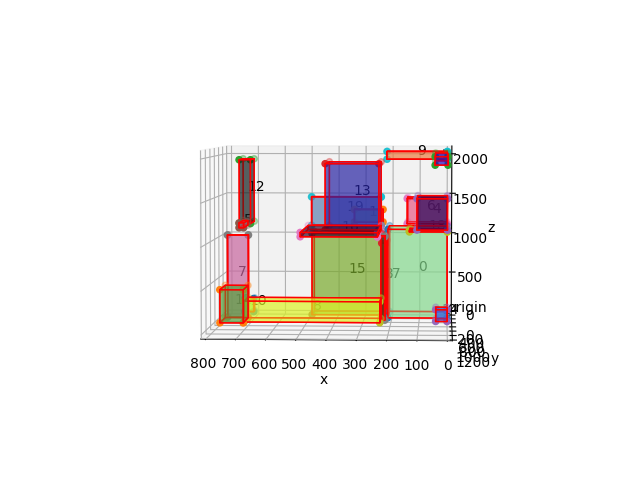


CpSolverResponse:
status: OPTIMAL
objective: 1
best_bound: 1
booleans: 1473
conflicts: 481
branches: 86574
propagations: 37321
integer_propagations: 17405
restarts: 2749
lp_iterations: 6
walltime: 1.21653
usertime: 1.21653
deterministic_time: 0.0233152
primal_integral: 0.0272022



In [46]:
solver = cp_model.CpSolver()
start_solve_time = time()
status = solver.Solve(model)
solve_time = time() - start_solve_time
print(f'Solve status: {solver.StatusName(status)}')
print(f'Solve time: {solve_time}')

if status == cp_model.OPTIMAL:
    print(f'Number of pallets: {solver.ObjectiveValue()}')
    print(f'Pallet dimensions: {pallet_lenght}x{pallet_width}x{max_product_height} mm')
    print(f'Pallet maximum load: {pallet_load} kg')
    print(f'Pallet liquid volume: {get_liquid_volume([[pallet_lenght, pallet_width, max_product_height]])} m3')
    print()
    for j in range(max_pallets):
        if solver.Value(pallet[j]):
            pallet_items, pallet_blbs, pallet_weights, pallet_dims = [], [], [], []
            print(f'Pallet #{j}')
            for i in range(ordered_products):
                if solver.Value(product_in_pallet[i, j]) > 0:
                    pallet_items.append(i)
                    pallet_blbs.append((
                        solver.Value(blb_corners_start[i].x),
                        solver.Value(blb_corners_start[i].y),
                        solver.Value(blb_corners_start[i].z)
                    ))
                    pallet_weights.append(order.iloc[i].weight)
                    pallet_dims.append([order.iloc[i].lenght, order.iloc[i].width, order.iloc[i].height])
                    print(f"\tProduct {i}")
                    print(f"\t\tBottom-left-back corner: {pallet_blbs[-1]}")
                    print(f"\t\tDimensions: {pallet_dims[-1][0]}x{pallet_dims[-1][1]}x{pallet_dims[-1][2]} mm")
                    print(f"\t\tWeight: {pallet_weights[-1]} kg")
            
            print(f'Total pallet weight: {sum(pallet_weights)} kg')
            print(f'Total pallet liquid volume: {get_liquid_volume(pallet_dims)} m3') 
            plot_pallet(
                order, 
                pallet_items,
                pallet_blbs, 
                pallet_lenght, 
                pallet_width, 
                max_product_height
            )
            print()
    print(solver.ResponseStats())
elif status == cp_model.MODEL_INVALID:
    print(model.Validate())

In [366]:
model._CpModel__model

variables {
  name: "product_in_pallet_0_0"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_1"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_2"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_3"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_4"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_5"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_6"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_7"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_8"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_9"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_1_0"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_1_1"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_1_2"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_1_3"
  domain: 0
  domain: 1
}
variables {
  name: 